# Imports

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import torch as T
from torch.utils.data import Dataset
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import gaussian_process
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm
from sklearn import discriminant_analysis
from sklearn import neural_network

import random

C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(0)
np.random.seed(0) 

# Reading

In [3]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(data_url, delimiter=';')

## Duplicates

In [4]:
df[df.duplicated()].shape[0]

240

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
df[df.duplicated()].shape[0]

0

## Null

In [7]:
df.isnull().values.any()

False

# First look

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


# Info 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.5 KB


# Target: Quality

In [10]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [11]:
df.groupby('quality')['quality'].count()

quality
3     10
4     53
5    577
6    535
7    167
8     17
Name: quality, dtype: int64

1. noteworthy that **quality is integer**, so no rates like 3.5 or 5.78
2. To normalize the quality we can simple minus 3 to all the values and we will have a range of 0...5 in stead of 3...8
2. dataset is very imbalanced

In [12]:
df['quality'] = df['quality'] - 3
df['quality'].unique()

array([2, 3, 4, 1, 5, 0], dtype=int64)

# Describe

In [13]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,2.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,2.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,3.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,3.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,5.000000


## Notes
1. Some like chlorides are very small numbers, some like "free sulfur dioxide" are high numbers. need to normalize.
2. Quality has min 3 max 8. Not from 1 to 10 or (0-9). also it's integer.
3. Intuitively feels that quality is not linearly depend on features. (in|de)creasing one of the params would not linearly (in|de)crease the quality. So I will treat the problem as **multiclass classification**.
4. Dropout thoughts. when we generalize something like used car prices it's clear than the older it is the less the price, and the more horsepowers it has the higher the price, so we use dropout a lot to make better picture on which feature influence the price more or less. When we deal with images we have only some area that is important and use dropout a lot to throw away the useless background. But in this particular case it feels like the combination of values influence quality, so I don't think that dropout is a good idea for this data.
5. Don't think ordinary humans can recognise the quality of wine using only numbers and no tasting it. I doubt the accuracy will be very high 

# Correlations

<Axes: >

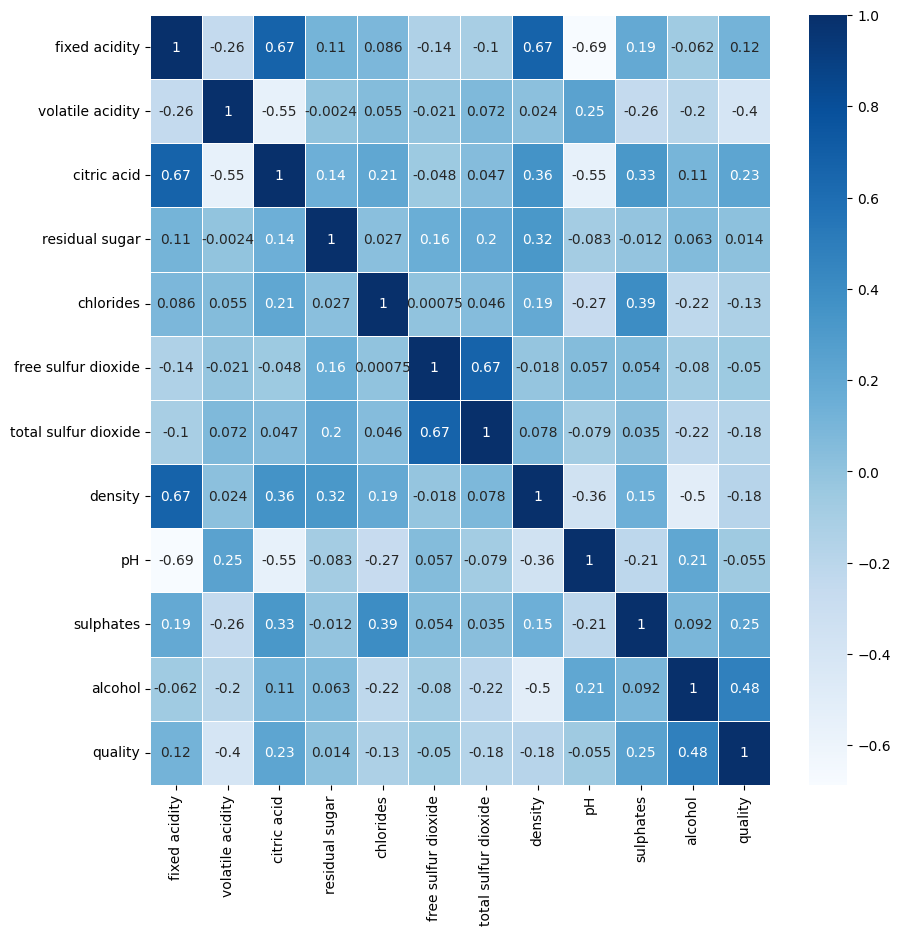

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True, linewidths=.5, ax=ax)

## Notes
1. Mostly weak correlations
2. Few high correlations (-0.69, 0.67)
3. we don't have much features, so it's doesn't looks like we need to reduce the number of input features

# First attempts
We will try to train some models from sklearn to see what result we could achieve "out from the box"

In [15]:
models_initial = [

    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0),
    
    gaussian_process.GaussianProcessClassifier(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    naive_bayes.MultinomialNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    neural_network.MLPClassifier(),
]

In [16]:
x = df.iloc[:,:11]
y = df['quality']

# sc = StandardScaler()
# x_new = sc.fit_transform(x)
x_new = x

for model in models_initial:
    print(model)
    best = 0
    avg = 0
    tries = 3
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

AdaBoostClassifier()
tries: 3, best acc: 0.5529411764705883, avg acc: 53.13725490196079
- - - - -
BaggingClassifier()
tries: 3, best acc: 0.5794117647058824, avg acc: 54.21568627450981
- - - - -
GradientBoostingClassifier()
tries: 3, best acc: 0.6029411764705882, avg acc: 58.725490196078425
- - - - -
ExtraTreesClassifier()
tries: 3, best acc: 0.6235294117647059, avg acc: 60.294117647058826
- - - - -
RandomForestClassifier(random_state=0)
tries: 3, best acc: 0.6205882352941177, avg acc: 59.50980392156863
- - - - -
GaussianProcessClassifier()
tries: 3, best acc: 0.4764705882352941, avg acc: 46.86274509803921
- - - - -
BernoulliNB()
tries: 3, best acc: 0.45, avg acc: 43.33333333333333
- - - - -
GaussianNB()
tries: 3, best acc: 0.5470588235294118, avg acc: 52.549019607843135
- - - - -
MultinomialNB()
tries: 3, best acc: 0.45, avg acc: 42.745098039215684
- - - - -
KNeighborsClassifier()
tries: 3, best acc: 0.4823529411764706, avg acc: 47.74509803921569
- - - - -
SVC(probability=True)
tries:

C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\discriminant_analysis.py:92

tries: 3, best acc: 0.5147058823529411, avg acc: 46.96078431372549
- - - - -
DecisionTreeClassifier()
tries: 3, best acc: 0.5058823529411764, avg acc: 49.41176470588235
- - - - -
ExtraTreeClassifier()
tries: 3, best acc: 0.5147058823529411, avg acc: 48.725490196078425
- - - - -
LinearDiscriminantAnalysis()
tries: 3, best acc: 0.5676470588235294, avg acc: 55.88235294117648
- - - - -
QuadraticDiscriminantAnalysis()
tries: 3, best acc: 0.5735294117647058, avg acc: 51.666666666666664
- - - - -
LogisticRegressionCV()


C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\Alex\anaconda3\envs\qi-ml-env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


tries: 3, best acc: 0.5705882352941176, avg acc: 55.490196078431374
- - - - -
PassiveAggressiveClassifier()
tries: 3, best acc: 0.5, avg acc: 43.03921568627451
- - - - -
RidgeClassifierCV()
tries: 3, best acc: 0.6029411764705882, avg acc: 57.94117647058824
- - - - -
SGDClassifier()
tries: 3, best acc: 0.538235294117647, avg acc: 45.3921568627451
- - - - -
Perceptron()
tries: 3, best acc: 0.40588235294117647, avg acc: 39.31372549019608
- - - - -
MLPClassifier()
tries: 3, best acc: 0.55, avg acc: 54.21568627450981
- - - - -


## Notes
1. the best are ExtraTreesClassifier RandomForestClassifier and SVC. We will keep only those for future
2. we have around 65-66 as of best ouf 200 tries and 58-59 avarage accuracy. we will take this is a starting point

In [17]:
models = [models_initial[3], models_initial[4], models_initial[9]]

## Evaluate

In [18]:
x = df.iloc[:,:11]
y = df['quality']

sc = StandardScaler()
x_new = sc.fit_transform(x)

for model in models:
    print(model)
    best = 0
    avg = 0
    tries = 50
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

ExtraTreesClassifier()
tries: 50, best acc: 0.6529411764705882, avg acc: 60.088235294117645
- - - - -
RandomForestClassifier(random_state=0)
tries: 50, best acc: 0.6558823529411765, avg acc: 60.01176470588237
- - - - -
KNeighborsClassifier()
tries: 50, best acc: 0.5970588235294118, avg acc: 53.52352941176472
- - - - -


## Notes
Let's see how we could imrove the numbers

# Distribution

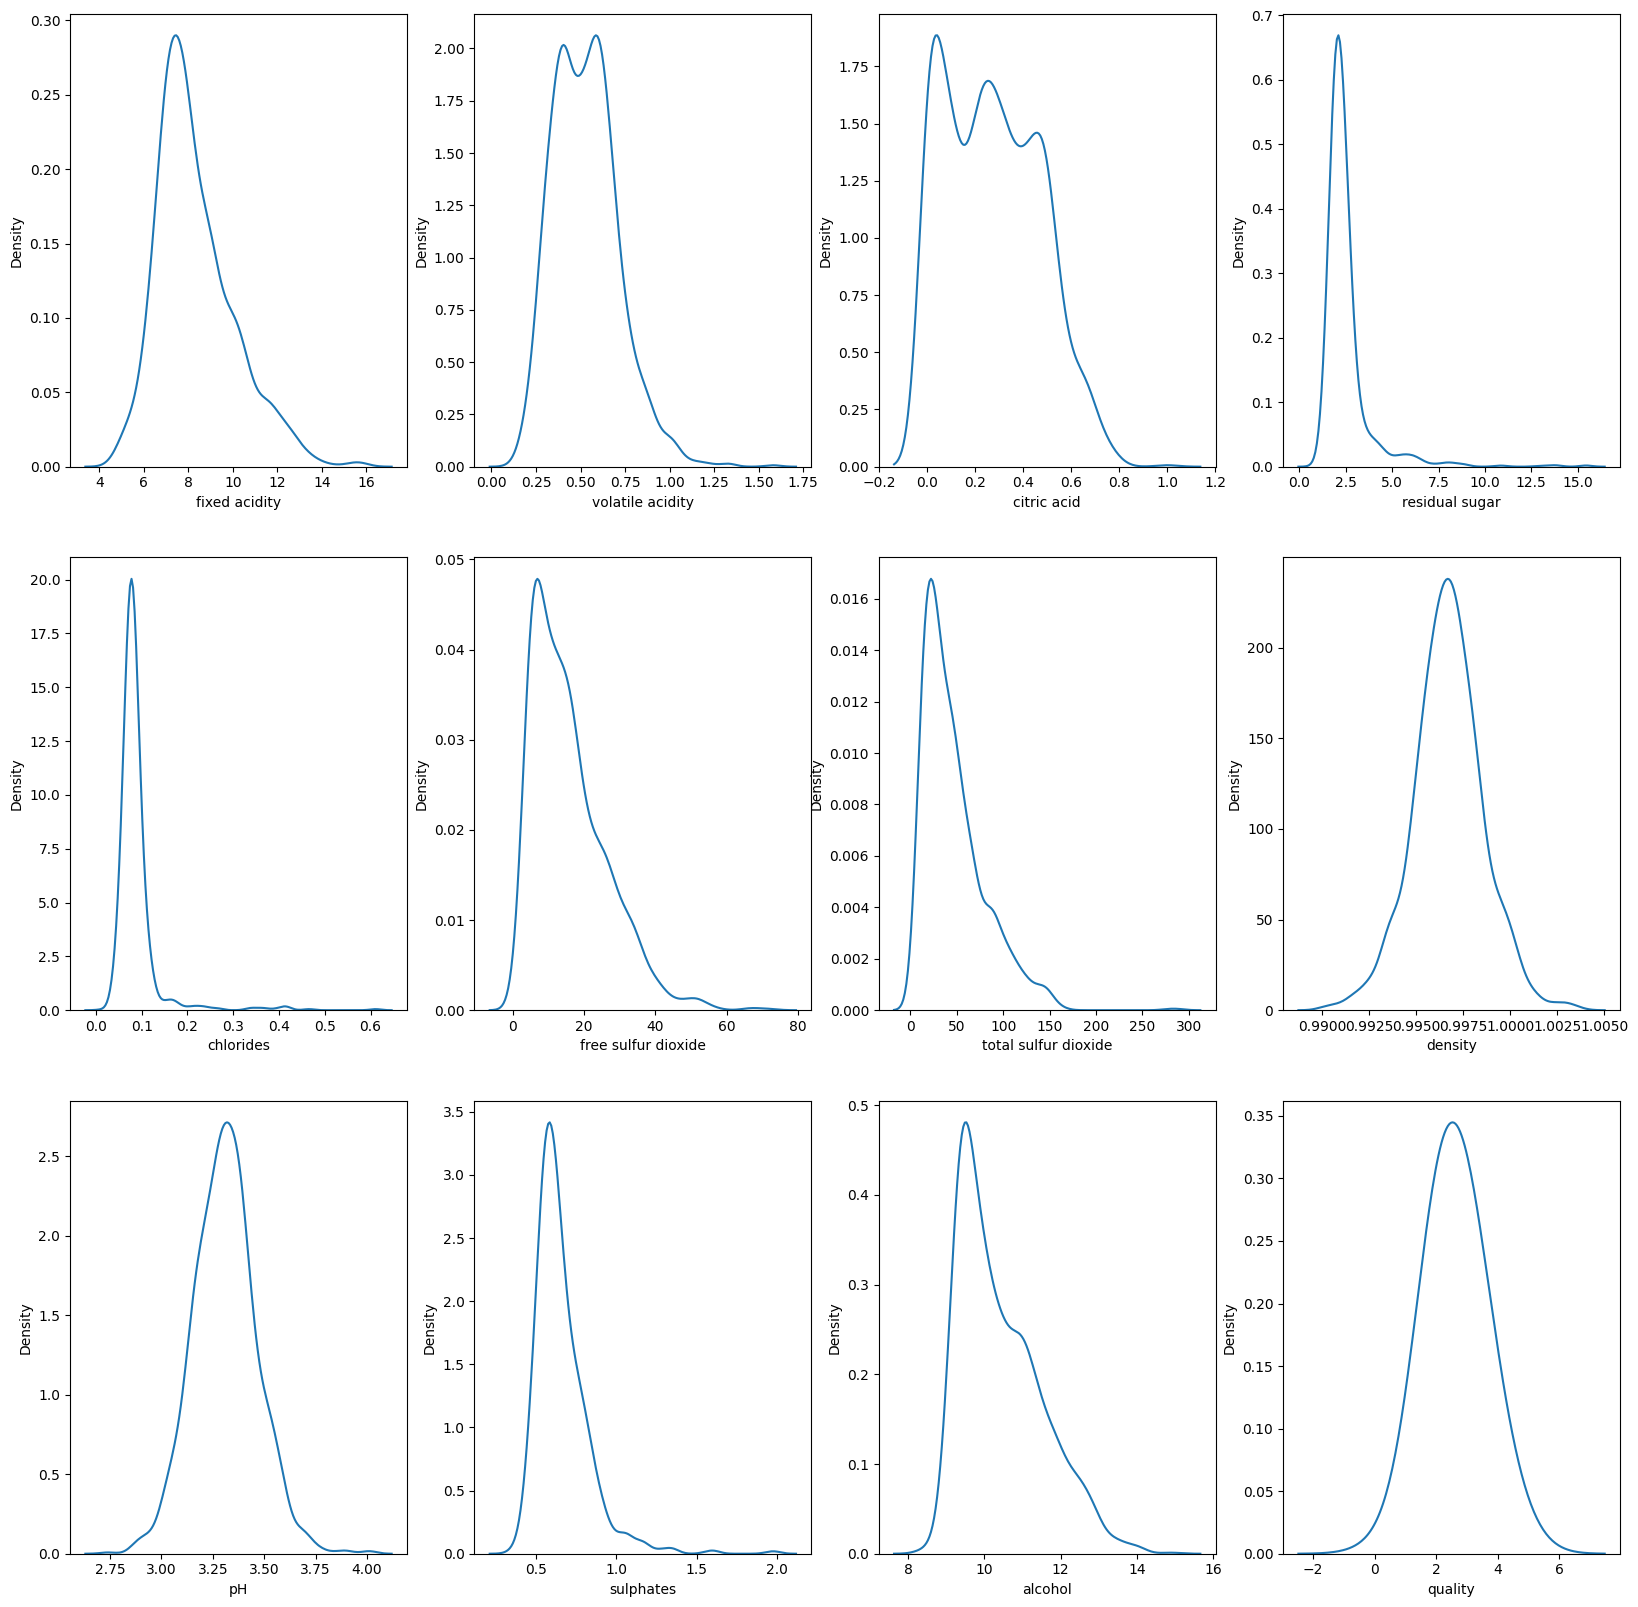

In [19]:
df_to_plot = df
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,20))

i = 0
for row in ax:
    for col in row:
        bw = 1 if df_to_plot.columns[i] == 'quality' else 'scott'
        sb.kdeplot(df_to_plot[df_to_plot.columns[i]], ax=col, bw_method=bw)
        i += 1

plt.show()

## Notes
1. we don't need to transform quality because it's our target. 
2. Density colimn looks gaussian already
3. Need to transform other data to better fit the normal distribution

In [20]:
df_to_transform = df[df.columns.difference(['quality', 'density'])]
df_to_transform.head()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,9.4,0.076,0.00,7.4,11.0,3.51,1.9,0.56,34.0,0.70
1,9.8,0.098,0.00,7.8,25.0,3.20,2.6,0.68,67.0,0.88
2,9.8,0.092,0.04,7.8,15.0,3.26,2.3,0.65,54.0,0.76
3,9.8,0.075,0.56,11.2,17.0,3.16,1.9,0.58,60.0,0.28
4,9.4,0.075,0.00,7.4,13.0,3.51,1.8,0.56,40.0,0.66


In [21]:
pt = PowerTransformer(method='yeo-johnson')
data = pt.fit_transform(df_to_transform)

In [22]:
df_power_transformed = pd.DataFrame(data, columns = df_to_transform.columns)

In [23]:
# density and quality from df
df_power_transformed = df_power_transformed.assign(density= df['density'], quality= df['quality'])

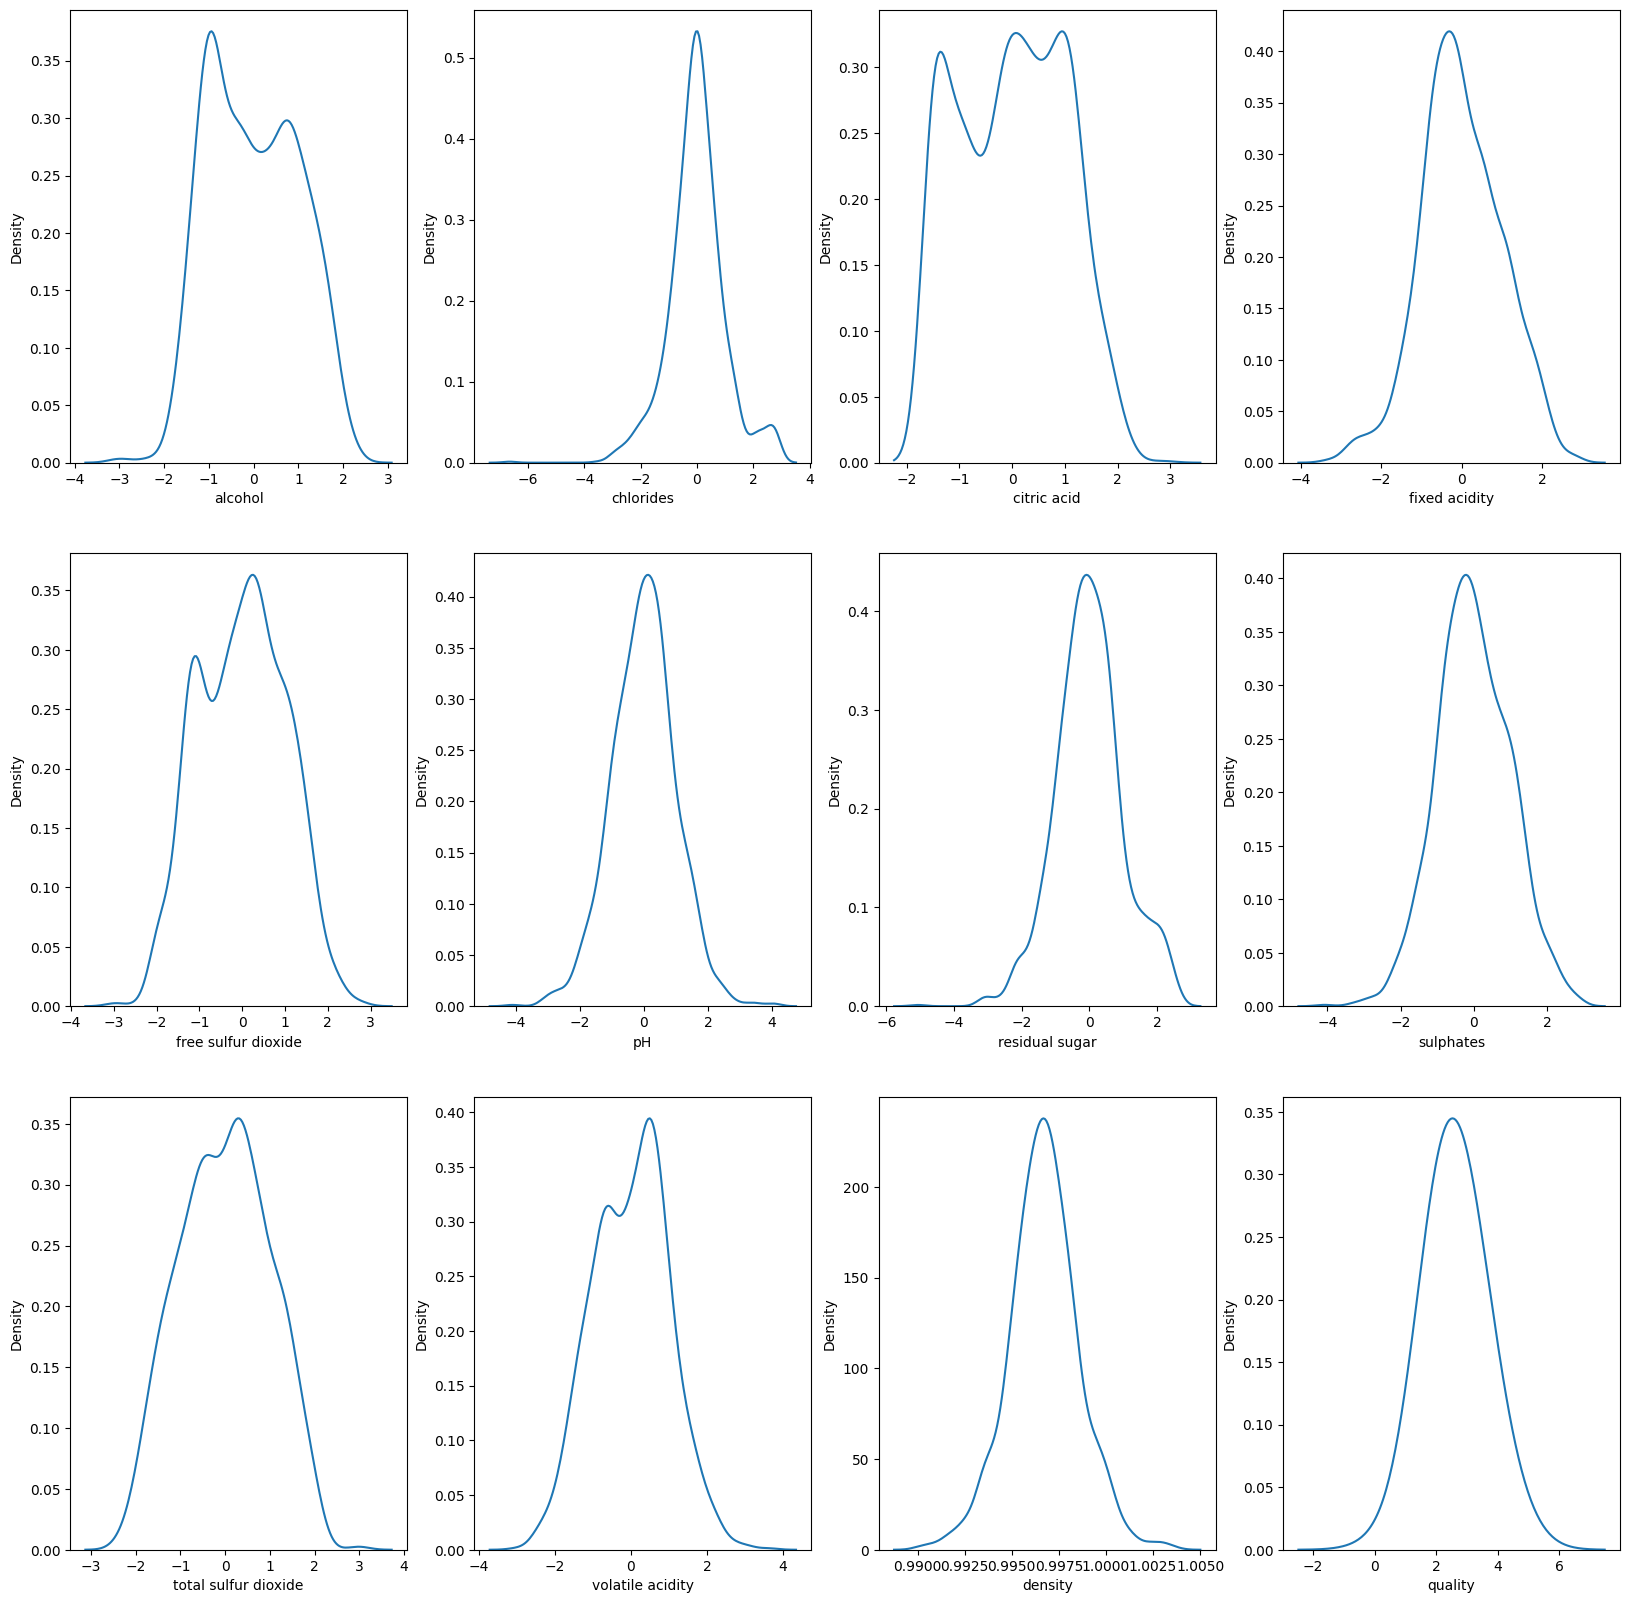

In [24]:
df_to_plot = df_power_transformed
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,20))

i = 0
for row in ax:
    for col in row:
        if i < len(df_to_plot.columns):
            bw = 1 if df_to_plot.columns[i] == 'quality' else 'scott'
            sb.kdeplot(df_to_plot[df_to_plot.columns[i]], ax=col, bw_method=bw)
            i += 1

plt.show()

# Normalize
Normalization is a commone technique to make small and big numbers equally improtant

In [25]:
_df = df_power_transformed.copy()
_df=(_df-_df.mean())/_df.std()
_df['quality'] = df_power_transformed['quality'].astype('int32')
df_transformed = _df
df_transformed.head()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity,density,quality
0,-1.067764,-0.166614,-1.529981,-0.439250,-0.269474,1.276571,-0.602378,-0.582561,-0.128901,0.977731,0.583788,2
1,-0.499106,0.778226,-1.529981,-0.161415,0.992130,-0.695651,0.560514,0.399983,0.841486,1.719407,0.048719,2
2,-0.499106,0.556911,-1.256500,-0.161415,0.192306,-0.295949,0.153020,0.188310,0.529817,1.241590,0.155733,2
3,-0.499106,-0.219288,1.389102,1.528447,0.383955,-0.967263,-0.602378,-0.391294,0.681715,-1.550932,0.690802,3
4,-1.067764,-0.219288,-1.529981,-0.439250,-0.023144,1.276571,-0.844253,-0.582561,0.100889,0.791370,0.583788,2


In [26]:
df_transformed.describe()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity,density,quality
count,1.359000e+03,1.359000e+03,1.359000e+03,1359.000000,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1359.000000
mean,-6.274108e-17,-3.137054e-17,4.182739e-17,0.000000,-2.614212e-17,3.137054e-17,3.137054e-17,5.228423e-18,-4.182739e-17,-1.045685e-17,5.286982e-14,2.623252
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.823578
min,-3.051520e+00,-6.653412e+00,-1.529981e+00,-3.342718,-2.953378e+00,-4.097380e+00,-5.062643e+00,-4.078587e+00,-2.417852e+00,-3.005325e+00,-3.552296e+00,0.000000
25%,-9.159111e-01,-4.977783e-01,-9.332996e-01,-0.663626,-9.053704e-01,-6.283971e-01,-6.023782e-01,-6.830531e-01,-7.344847e-01,-7.429644e-01,-5.933638e-01,2.000000
50%,-2.192012e-02,-1.429798e-02,3.589744e-02,-0.095447,8.793382e-02,3.027648e-02,-9.272967e-03,-4.427169e-02,2.816475e-02,6.294420e-02,-4.787669e-03,3.000000
75%,8.006657e-01,5.176240e-01,8.482931e-01,0.656064,7.139812e-01,6.023918e-01,5.605138e-01,7.121753e-01,7.522726e-01,6.948260e-01,5.944898e-01,3.000000
max,2.373194e+00,2.809959e+00,2.857542e+00,2.833375,2.781945e+00,4.036191e+00,2.567264e+00,2.866312e+00,3.014591e+00,3.629938e+00,3.735346e+00,5.000000


## Notes
1. looks better

## Evaluate

In [27]:
x = df_transformed.iloc[:,:11]
y = df_transformed['quality']

sc = StandardScaler()
x_new = sc.fit_transform(x)

for model in models:
    print(model)
    best = 0
    avg = 0
    tries = 50
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

ExtraTreesClassifier()
tries: 50, best acc: 0.6588235294117647, avg acc: 60.3235294117647
- - - - -
RandomForestClassifier(random_state=0)
tries: 50, best acc: 0.638235294117647, avg acc: 59.33529411764706
- - - - -
KNeighborsClassifier()
tries: 50, best acc: 0.6058823529411764, avg acc: 55.27647058823531
- - - - -


## Notes
Numbers are slightly better

## Try polinomial features

In [28]:
df_to_use = df_transformed.copy()
x = df_to_use.iloc[:,:11]
y = df_to_use['quality'].copy()

poly = PolynomialFeatures(2, interaction_only=True)
x = poly.fit_transform(x)
print(x.shape, y.shape)

sc = StandardScaler()
x_new = sc.fit_transform(x)

for model in models:
    print(model)
    best = 0
    avg = 0
    tries = 50
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

(1359, 67) (1359,)
ExtraTreesClassifier()
tries: 50, best acc: 0.638235294117647, avg acc: 59.29411764705881
- - - - -
RandomForestClassifier(random_state=0)
tries: 50, best acc: 0.6470588235294118, avg acc: 59.10000000000001
- - - - -
KNeighborsClassifier()
tries: 50, best acc: 0.6029411764705882, avg acc: 55.000000000000014
- - - - -


# Imbalanced dataset

In [29]:
df_to_resample = df_transformed.copy()
df_to_resample.groupby('quality')['quality'].count()

quality
0     10
1     53
2    577
3    535
4    167
5     17
Name: quality, dtype: int64

## Attempts to deal with it
we have the most of class 2. what if we train binnary classifier to classify only class 2. our dataset will be more or less balanced.

In [30]:
df_to_use = df_to_resample.copy()
x = df_to_use.iloc[:,:11]
y = df_to_use['quality'].copy()
y = y == 2

# poly = PolynomialFeatures(2, interaction_only=True)
# x = poly.fit_transform(x)
# print(x.shape, y.shape)
print("class 2: %s, other: %s" % (y[y == True].shape[0], y[y == False].shape[0]))

sc = StandardScaler()
x_new = sc.fit_transform(x)

for model in models:
    print(model)
    best = 0
    avg = 0
    tries = 5
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

class 2: 577, other: 782
ExtraTreesClassifier()
tries: 5, best acc: 0.7911764705882353, avg acc: 76.58823529411765
- - - - -
RandomForestClassifier(random_state=0)
tries: 5, best acc: 0.7558823529411764, avg acc: 74.0
- - - - -
KNeighborsClassifier()
tries: 5, best acc: 0.7647058823529411, avg acc: 73.47058823529412
- - - - -


## Notes
Comparing to 63% 64% on multiclass classification 77% on binarry classifying class 2 only doesn't look like a great improvement. 

## Class 2 against 3

In [31]:
df_to_use = df_to_resample.copy()
df_to_use = df_to_use[(df_to_use['quality'] == 2) | (df_to_use['quality'] == 3)]
x = df_to_use.iloc[:,:11]
y = df_to_use['quality'].copy()
y = y == 2

# poly = PolynomialFeatures(2, interaction_only=True)
# x = poly.fit_transform(x)
# print(x.shape, y.shape)
print("class 2: %s, class 3: %s" % (y[y == True].shape[0], y[y == False].shape[0]))

sc = StandardScaler()
x_new = sc.fit_transform(x)

for model in models:
    print(model)
    best = 0
    avg = 0
    tries = 5
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

class 2: 577, class 3: 535
ExtraTreesClassifier()
tries: 5, best acc: 0.762589928057554, avg acc: 72.9496402877698
- - - - -
RandomForestClassifier(random_state=0)
tries: 5, best acc: 0.7194244604316546, avg acc: 70.14388489208632
- - - - -
KNeighborsClassifier()
tries: 5, best acc: 0.7122302158273381, avg acc: 68.27338129496403
- - - - -


## Notes
This feels like very not trivial task to distinguish classes 2 from 3. May be they are not that different

## Trying to reduce the output 
let's combine classes 0 and 1, 2 and 3, 4 and 5. To have 3 classes in total, like 'dab', 'ok', 'good'. May be difference will be more obvoius. 

In [32]:
df_to_resample['quality_simplified'] = ((df_to_resample['quality'] / 2)).apply(np.floor).astype(int)
df_to_resample.groupby('quality_simplified')['quality_simplified'].count()

quality_simplified
0      63
1    1112
2     184
Name: quality_simplified, dtype: int64

In [33]:
df_to_use = df_to_resample.copy()
x = df_to_use.iloc[:,:11]
y = df_to_use['quality_simplified'].copy()

sc = StandardScaler()
x_new = sc.fit_transform(x)

for model in models:
    print(model)
    best = 0
    avg = 0
    tries = 5
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x_new.copy(), y.copy(), test_size = 0.25)
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        model_conf_matrix = confusion_matrix(y_test, model_predict)
        model_acc_score = accuracy_score(y_test, model_predict)
        if model_acc_score > best:
            best = model_acc_score
        avg += model_acc_score * 100 / tries
    print('tries: %s, best acc: %s, avg acc: %s' % (tries, best, avg))
    print('- - - - -')

ExtraTreesClassifier()
tries: 5, best acc: 0.8529411764705882, avg acc: 83.58823529411765
- - - - -
RandomForestClassifier(random_state=0)
tries: 5, best acc: 0.8470588235294118, avg acc: 82.8235294117647
- - - - -
KNeighborsClassifier()
tries: 5, best acc: 0.85, avg acc: 81.88235294117646
- - - - -


## Notes
84% 87%. Can human do better?